## Multi-Cell NOMA

### Necessary Imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np
import simcomm.metrics as metrics
import simcomm.utils as utils
from simcomm.fading import generate_channel
from simcomm.visualize import plot_network

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

os.makedirs("./data/mc_noma", exist_ok=True)
save_dir = os.path.abspath("./data/mc_noma/")

### System Model

Parameters

In [2]:
# Multi-cell NOMA
N = 3  # Number of users
N_index = np.arange(N)  # Index of users
M = 2  # Number of BSs
M_index = np.arange(M)  # Index of BSs
T = 290  # Temperature in Kelvin
BANDWIDTH = 10e6  # bandwidth in Hz
NOISE = utils.get_noise(BANDWIDTH, T, 43)  # noise power in dBm
NOISE_LIN = utils.dbm2pow(NOISE)  # noise power in linear scale
S = 10000  # Number of monte carlo simulations

# Power parameters
Pt = np.linspace(-40, 20, 120)  # transmit power in dBm
Pt_lin = utils.dbm2pow(Pt)  # transmit power in linear scale
P_circuit = 10e-5  # circuit power in Watts

Creating Layout (Example)

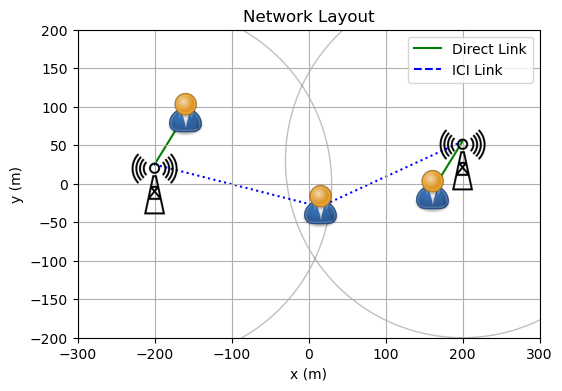

In [3]:
# Placing the base stations
bs_pos = np.array([[-200, 0, 10], [200, 30, 10]])
user_pos = np.array([[-160, 90, 0], [15, -30, 0], [160, -10, 0]])

# Plotting the network
plot_network(300, 230, bs_pos, user_pos)

### Monte Carlo Simulations

In [4]:
rate = np.zeros((S, N))
sum_rate = np.zeros((S, len(Pt_lin)))
outage = np.zeros((S, N, len(Pt_lin)))
energy_eff = np.zeros((S, len(Pt_lin)))
spectral_eff = np.zeros((S, len(Pt_lin)))
target_rate = 1

for mc in range(S):
    utils.randomize_user_pos(bs_pos, user_pos, edge_idx=1, r_min=30, r_max=90)

    # Find distances between users and base stations
    distance_mat = np.zeros((M, N), dtype=np.float32)

    for m in range(M):
        for n in range(N):
            distance_mat[m, n] = utils.distance(bs_pos[m], user_pos[n], dim=3)

    # Compute the channel gains
    g = np.zeros((M, N), dtype=np.float32)

    for m in range(M):
        for n in range(N):
            ETA = 3.5 if (n == 0 or n == 2) else 4
            g[m, n] = generate_channel("rayleigh", distance_mat[m, n], ETA)

    # Assigning alpha factors for fixed allocation
    alpha_1f = 0.75  # for cell-edge user by BS 1
    alpha_2f = 0.83  # for cell-edge user by BS 2

    for i in range(len(Pt_lin)):
        # Rate for user 1
        gamma_1c = Pt_lin[i] * g[0, 0] / (NOISE_LIN)  # 1c: center user of cell 1 (BS 1)
        rate[mc, 0] = np.log2(1 + ((1 - alpha_1f) * gamma_1c))

        # Rate for user 3
        gamma_2c = Pt_lin[i] * g[1, 2] / (NOISE_LIN)  # 2c: center user of cell 2 (BS 2)
        rate[mc, 2] = np.log2(1 + ((1 - alpha_2f) * gamma_2c))

        # Rate for user 2
        gamma_1f = (
            Pt_lin[i] * g[0, 1] / (Pt_lin[i] * g[1, 1] + NOISE_LIN)
        )  # 1f: edge user of cell 1 (BS 1)
        gamma_2f = (
            Pt_lin[i] * g[1, 1] / (Pt_lin[i] * g[0, 1] + NOISE_LIN)
        )  # 2f: edge user of cell 2 (BS 2)
        rate[mc, 1] = np.log2(
            1
            + ((alpha_1f * gamma_1f) + (alpha_2f * gamma_2f))
            / (((1 - alpha_1f) * gamma_1f) + ((1 - alpha_2f) * gamma_2f) + 1)
        )

        # Sum rate
        sum_rate[mc, i] = np.sum(rate[mc, :])

        # Outage
        outage[mc, 0, i] = metrics.outage_probability(rate[mc, 0], target_rate)
        outage[mc, 1, i] = metrics.outage_probability(rate[mc, 1], target_rate)
        outage[mc, 2, i] = metrics.outage_probability(rate[mc, 2], target_rate)

        # Energy efficiency
        energy_eff[mc, i] = sum_rate[mc, i] / (Pt_lin[i] + P_circuit)

        # Spectral efficiency
        spectral_eff[mc, i] = sum_rate[mc, i]  # already normalized by bandwidth

# Averaging over all monte carlo simulations
avg_sum_rate = np.mean(sum_rate, axis=0)
avg_outage = np.mean(outage, axis=0)
avg_energy_eff = np.mean(energy_eff, axis=0)
avg_spectral_eff = np.mean(spectral_eff, axis=0)

### Plots

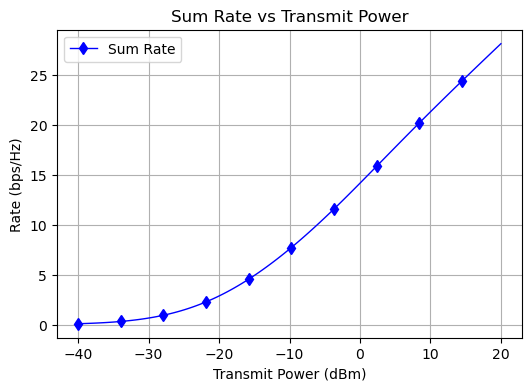

In [5]:
# Sum rate vs transmit power
np.save(os.path.join(save_dir, "sum_rate.npy"), avg_sum_rate)

fig = plt.figure(figsize=(6, 4))
plt.plot(
    Pt, avg_sum_rate, "b-", label="Sum Rate", linewidth=1, marker="d", markevery=12
)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("Sum Rate vs Transmit Power")
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_dir, "sum_rate.pdf"), bbox_inches="tight")
plt.show()

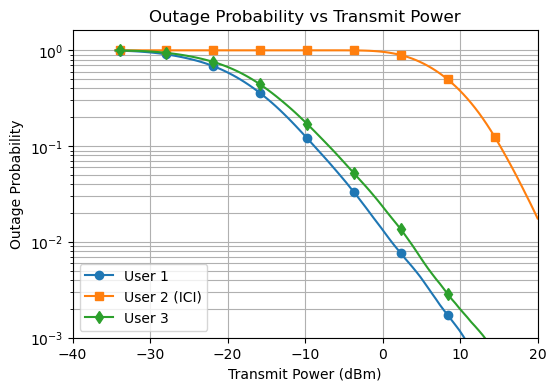

In [6]:
# Outage probability vs transmit power
window_size = 12
rolling_outage = np.zeros((N, len(Pt)))
for i in range(N):
    rolling_outage[i] = utils.rolling_mean(avg_outage[i], window_size)

np.save(os.path.join(save_dir, "outage.npy"), rolling_outage)

fig, ax = plt.subplots(figsize=(6, 4))
plt.semilogy(Pt, rolling_outage[0], label="User 1", marker="o", markevery=12)
plt.semilogy(Pt, rolling_outage[1], label="User 2 (ICI)", marker="s", markevery=12)
plt.semilogy(Pt, rolling_outage[2], label="User 3", marker="d", markevery=12)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("Outage Probability vs Transmit Power")
plt.xlim(-40, 20)
plt.ylim(1e-3, None)
plt.legend()
plt.grid(which="both")
plt.savefig(os.path.join(save_dir, "outage.pdf"), bbox_inches="tight")
plt.show()

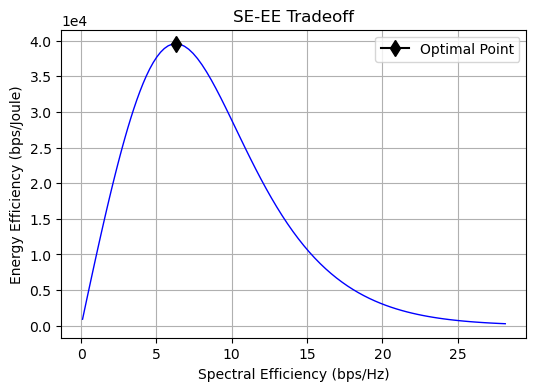

In [7]:
# SE-EE tradeoff
np.save(os.path.join(save_dir, "avg_spectral_eff.npy"), avg_spectral_eff)
np.save(os.path.join(save_dir, "avg_energy_eff.npy"), avg_energy_eff)

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(avg_spectral_eff, avg_energy_eff, "b-", linewidth=1)
plt.xlabel("Spectral Efficiency (bps/Hz)")
plt.ylabel("Energy Efficiency (bps/Joule)")
plt.title("SE-EE Tradeoff")
plt.grid()

# Find the peak point
peak_idx = np.argmax(avg_energy_eff)
peak_x = avg_spectral_eff[peak_idx]
peak_y = avg_energy_eff[peak_idx]

# Add a marker at the peak point
plt.plot(peak_x, peak_y, marker="d", markersize=8, color="black", label="Optimal Point")
plt.legend()

plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.savefig(os.path.join(save_dir, "se_ee_tradeoff.pdf"), bbox_inches="tight")
plt.show()